In [2]:
import pandas as pd

data = pd.read_parquet("model_features.parquet")
data

,municipality_id,% Forest,% Crops,% Flatlands,% Built-up,% Wetlands,% Protected Area
0,1.028030e+08,0.046231,0.421475,0.443372,0.059711,0.028706,0.001027
1,1.028120e+08,0.000401,0.485153,0.316229,0.147883,0.049561,0.000000
2,1.028150e+08,0.503109,0.137716,0.318179,0.030086,0.009873,0.180760
3,1.028160e+08,0.001565,0.497563,0.376649,0.074523,0.049620,0.054449
4,1.028230e+08,0.190629,0.094527,0.693880,0.008286,0.012678,0.005622
...,...,...,...,...,...,...,...
737,1.908816e+09,0.000000,0.220524,0.001030,0.011617,0.766829,0.000000
738,1.908818e+09,0.000000,0.798091,0.015941,0.047773,0.138195,0.000000
739,1.908820e+09,0.000000,0.854234,0.006270,0.116677,0.022819,0.000000
740,1.908821e+09,0.000000,0.750004,0.113976,0.035925,0.100095,0.000000


$$sample\ weight = \frac{no.\ of\ suitable\ sites}{municipality\ area}$$
$$scaled\ weight = \frac{sample\ weight - min(sample\ weight)}{max(sample\ weight) - min(sample\ weight)}$$

In [3]:
# Get count of suitable sites and area
import geopandas as gpd
import numpy as np

muni_gdf = gpd.read_parquet("data/NEW_municipalities.parquet")
muni_gdf['area'] = muni_gdf.geometry.area / 1e6  # Convert to km2
muni_gdf = muni_gdf[["adm3_psgc", "Count", "area"]]
muni_gdf['weight'] = muni_gdf['Count'] / muni_gdf['area']

min_weight = muni_gdf['weight'].min()
max_weight = muni_gdf['weight'].max()
muni_gdf['normalized_weight'] = (muni_gdf['weight'] - min_weight) / (max_weight - min_weight)

# Rename adm3_psgc to municipality_id
muni_gdf = muni_gdf.rename(columns={"adm3_psgc": "municipality_id"})

muni_gdf

,municipality_id,Count,area,weight,normalized_weight
0,1.028030e+08,1,80.758429,0.012383,0.008763
1,1.028120e+08,1,110.146975,0.009079,0.006281
2,1.028150e+08,2,193.261277,0.010349,0.007235
3,1.028160e+08,1,69.564806,0.014375,0.010260
4,1.028230e+08,2,531.249117,0.003765,0.002290
...,...,...,...,...,...
737,1.908816e+09,2,198.328295,0.010084,0.007037
738,1.908818e+09,1,44.662781,0.022390,0.016280
739,1.908820e+09,1,36.575548,0.027341,0.019999
740,1.908821e+09,2,55.909439,0.035772,0.026332


In [4]:
normalized_weight = muni_gdf[["municipality_id", "normalized_weight"]]

# Join with the original data
data = data.merge(normalized_weight, on="municipality_id", how="left")
data = data.rename(columns={"normalized_weight": "weight"})

# Count null values in the weight column
null_count = data['weight'].isnull().sum()
print(f"Number of null values in the weight column: {null_count}")

# Check for duplicates in the municipality_id column
duplicates = data['municipality_id'].duplicated().sum()
print(f"Number of duplicate municipality_id values: {duplicates}")

data

Number of null values in the weight column: 0
Number of duplicate municipality_id values: 0


,municipality_id,% Forest,% Crops,% Flatlands,% Built-up,% Wetlands,% Protected Area,weight
0,1.028030e+08,0.046231,0.421475,0.443372,0.059711,0.028706,0.001027,0.008763
1,1.028120e+08,0.000401,0.485153,0.316229,0.147883,0.049561,0.000000,0.006281
2,1.028150e+08,0.503109,0.137716,0.318179,0.030086,0.009873,0.180760,0.007235
3,1.028160e+08,0.001565,0.497563,0.376649,0.074523,0.049620,0.054449,0.010260
4,1.028230e+08,0.190629,0.094527,0.693880,0.008286,0.012678,0.005622,0.002290
...,...,...,...,...,...,...,...,...
737,1.908816e+09,0.000000,0.220524,0.001030,0.011617,0.766829,0.000000,0.007037
738,1.908818e+09,0.000000,0.798091,0.015941,0.047773,0.138195,0.000000,0.016280
739,1.908820e+09,0.000000,0.854234,0.006270,0.116677,0.022819,0.000000,0.019999
740,1.908821e+09,0.000000,0.750004,0.113976,0.035925,0.100095,0.000000,0.026332


# Model Training

In [5]:
feature_names = data.columns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Drop ID column if it's the first column
X = data.iloc[:, 1:].values  # Assuming the first column is ID

# Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, train_indices, test_indices = train_test_split(X, np.arange(X.shape[0]), test_size=0.2, random_state=42)

train_weights = X_train[:, -1]  
X_train = X_train[:, :-1]  # Drop the last column (weight)
X_test = X_test[:, :-1]  # Drop the last column (weight)

# Prepare a dictionary to store results
results = {}

## Isolation Forest

In [68]:
iso_forest = IsolationForest(n_estimators=100, max_samples=256, contamination="auto", random_state=42, n_jobs=-1)
iso_forest.fit(X_train, sample_weight=train_weights)

train_preds_iso = iso_forest.predict(X_train)
test_preds_iso = iso_forest.predict(X_test)

train_anomalies_iso = np.where(train_preds_iso == -1, 1, 0)
test_anomalies_iso = np.where(test_preds_iso == -1, 1, 0)

silhouette_train_iso = silhouette_score(X_train, train_anomalies_iso)
silhouette_test_iso = silhouette_score(X_test, test_anomalies_iso)

results['Isolation Forest'] = {
    'Train Silhouette Score': silhouette_train_iso,
    'Test Silhouette Score': silhouette_test_iso
}

## One-Class SVM

In [69]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
ocsvm.fit(X_train)

train_preds_ocsvm = ocsvm.predict(X_train)
test_preds_ocsvm = ocsvm.predict(X_test)

train_anomalies_ocsvm = np.where(train_preds_ocsvm == -1, 1, 0)
test_anomalies_ocsvm = np.where(test_preds_ocsvm == -1, 1, 0)

silhouette_train_ocsvm = silhouette_score(X_train, train_anomalies_ocsvm)
silhouette_test_ocsvm = silhouette_score(X_test, test_anomalies_ocsvm)

results['One-Class SVM'] = {
    'Train Silhouette Score': silhouette_train_ocsvm,
    'Test Silhouette Score': silhouette_test_ocsvm
}



## Local Outlier Factor

In [70]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
train_preds_lof = lof.fit_predict(X_train)
test_preds_lof = lof.fit_predict(X_test)

train_anomalies_lof = np.where(train_preds_lof == -1, 1, 0)
test_anomalies_lof = np.where(test_preds_lof == -1, 1, 0)

silhouette_train_lof = silhouette_score(X_train, train_anomalies_lof)
silhouette_test_lof = silhouette_score(X_test, test_anomalies_lof)

results['Local Outlier Factor'] = {
    'Train Silhouette Score': silhouette_train_lof,
    'Test Silhouette Score': silhouette_test_lof
}

## KMeans

In [71]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)

train_distances_kmeans = kmeans.transform(X_train).min(axis=1)
test_distances_kmeans = kmeans.transform(X_test).min(axis=1)

threshold_kmeans = np.percentile(train_distances_kmeans, 95)
train_anomalies_kmeans = np.where(train_distances_kmeans > threshold_kmeans, 1, 0)
test_anomalies_kmeans = np.where(test_distances_kmeans > threshold_kmeans, 1, 0)

silhouette_train_kmeans = silhouette_score(X_train, train_anomalies_kmeans)
silhouette_test_kmeans = silhouette_score(X_test, test_anomalies_kmeans)

results['KMeans'] = {
    'Train Silhouette Score': silhouette_train_kmeans,
    'Test Silhouette Score': silhouette_test_kmeans
}


## AutoEncoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Use Sigmoid for reconstruction between [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Instantiate model, define loss and optimizer
model = AutoEncoder(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the AutoEncoder
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_data in train_loader:
        optimizer.zero_grad()
        reconstructed = model(batch_data[0])
        loss = criterion(reconstructed, batch_data[0])
        loss.backward()
        optimizer.step()

# Get reconstruction error on train and test data
model.eval()
train_reconstruction = model(X_train_tensor).detach().numpy()
test_reconstruction = model(X_test_tensor).detach().numpy()

train_reconstruction_error = np.mean(np.square(X_train - train_reconstruction), axis=1)
test_reconstruction_error = np.mean(np.square(X_test - test_reconstruction), axis=1)

threshold_autoencoder = np.percentile(train_reconstruction_error, 95)
train_anomalies_autoencoder = np.where(train_reconstruction_error > threshold_autoencoder, 1, 0)
test_anomalies_autoencoder = np.where(test_reconstruction_error > threshold_autoencoder, 1, 0)

silhouette_train_autoencoder = silhouette_score(X_train, train_anomalies_autoencoder)
silhouette_test_autoencoder = silhouette_score(X_test, test_anomalies_autoencoder)

results['AutoEncoder'] = {
    'Train Silhouette Score': silhouette_train_autoencoder,
    'Test Silhouette Score': silhouette_test_autoencoder
}

torch.save(model.state_dict(), "autoencoder_weights.pth")


#### Inference

In [14]:
import json

params = {
    "num_features": 6,
    "threshold_autoencoder": threshold_autoencoder
}

with open("model_params/autoencoder_params.json", "w") as f:
    json.dump(params, f, indent=4)

In [16]:
with open("model_params/autoencoder_params.json", "r") as f:
    loaded_params = json.load(f)

num_features = loaded_params["num_features"]
threshold_autoencoder = loaded_params["threshold_autoencoder"]

In [ ]:
# Instantiate the model again
loaded_model = AutoEncoder(input_dim=num_features)

# Load the trained weights
loaded_model.load_state_dict(torch.load("autoencoder_weights.pth"))

# Set the model to evaluation mode
loaded_model.eval()


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
    (5): Sigmoid()
  )
)

In [17]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    test_reconstruction = loaded_model(X_test_tensor).numpy()
    test_reconstruction_error = np.mean(np.square(X_test - test_reconstruction), axis=1)
    threshold_autoencoder = np.percentile(train_reconstruction_error, 95)
    test_anomalies_autoencoder = np.where(test_reconstruction_error > threshold_autoencoder, 1, 0)
    print(test_anomalies_autoencoder)

[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


## Compile Results

In [78]:
import pandas as pd

# Initialize an empty list to store the results
results_list = []

# Loop through the results dictionary and extract the model scores
for model_name, scores in results.items():
    row = {'Model': model_name}
    for score_name, score_value in scores.items():
        row[score_name] = score_value
    results_list.append(row)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='Test Silhouette Score', ascending=False).reset_index(drop=True)

# Print the DataFrame
results_df

,Model,Train Silhouette Score,Test Silhouette Score
0,AutoEncoder,0.464638,0.523555
1,KMeans,0.410106,0.517584
2,Isolation Forest,0.406862,0.462769
3,One-Class SVM,0.376356,0.365951
4,Local Outlier Factor,0.115558,0.362821


# Analysis

In [88]:
# Concatenate anomalies from train and test data
anomalous_indices = np.concatenate((train_indices[train_anomalies_autoencoder == 1], 
                                    test_indices[test_anomalies_autoencoder == 1]))

# Retrieve anomalous data using the original indices
anomalous_data = data.iloc[anomalous_indices]
anomalous_data

,municipality_id,% Forest,% Crops,% Flatlands,% Built-up,% Wetlands,% Protected Area,weight
218,4.058120e+08,0.070153,0.119616,0.760686,0.040321,0.009225,0.813290,0.007402
486,9.083080e+08,0.000000,0.897689,0.017358,0.023645,0.059089,0.936404,0.005670
706,1.903626e+09,0.000000,0.858561,0.043064,0.097421,0.000955,1.000000,0.088630
182,4.021170e+08,0.000000,0.000000,0.099291,0.865228,0.033762,0.000000,0.280925
680,1.705307e+09,0.290100,0.029381,0.614462,0.016250,0.045768,0.993146,0.003169
536,1.102404e+09,0.000000,0.887099,0.013642,0.051755,0.047116,0.875845,0.005641
534,1.102401e+09,0.181248,0.652686,0.133438,0.029795,0.002833,1.131480,0.002960
93,3.014090e+08,0.000000,0.040852,0.002047,0.098276,0.847972,0.000000,0.017464
581,1.380100e+09,0.004339,0.008632,0.056350,0.921983,0.008696,0.000000,0.027674
195,4.034250e+08,0.000000,0.014699,0.091775,0.857640,0.035886,0.000000,0.155516


In [1]:
# Concatenate anomalies from train and test data
normal_indices = np.concatenate((train_indices[train_anomalies_autoencoder == 0], 
                                    test_indices[test_anomalies_autoencoder == 0]))

# Retrieve anomalous data using the original indices
normal_data = data.iloc[normal_indices]
normal_data

NameError: name 'np' is not defined

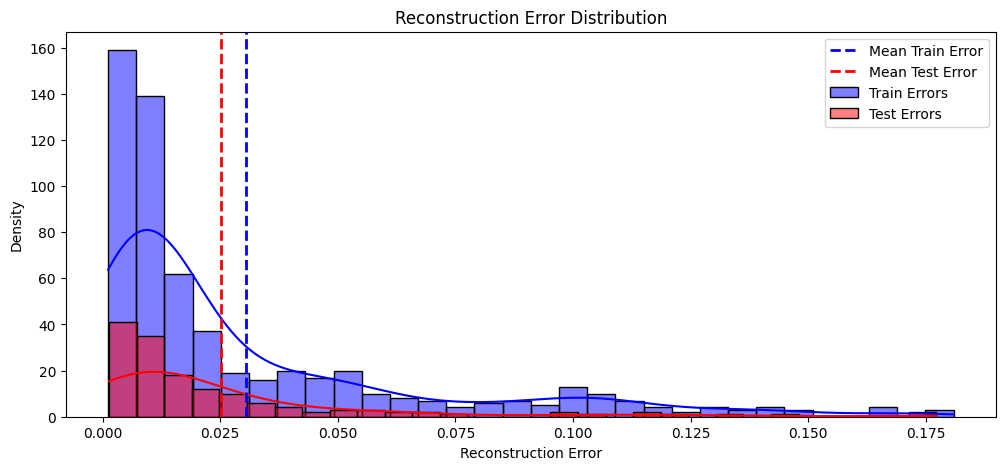

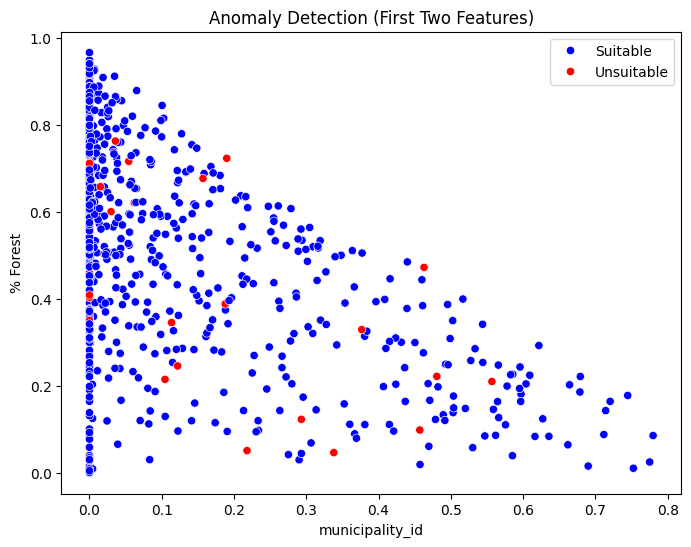

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Visualization 1: Distribution of Anomaly Scores (Reconstruction Errors)
plt.figure(figsize=(12, 5))
sns.histplot(train_reconstruction_error, bins=30, kde=True, color='blue', label='Train Errors')
sns.histplot(test_reconstruction_error, bins=30, kde=True, color='red', label='Test Errors')
plt.axvline(np.mean(train_reconstruction_error), color='blue', linestyle='dashed', linewidth=2, label='Mean Train Error')
plt.axvline(np.mean(test_reconstruction_error), color='red', linestyle='dashed', linewidth=2, label='Mean Test Error')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.show()

# Visualization 2: Scatter Plot of Anomalies in 2D (using first two features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=np.concatenate((train_anomalies_autoencoder, test_anomalies_autoencoder)), 
                palette={0: "blue", 1: "red"}, legend=True)  # Using '0' for normal, '1' for anomalies
plt.title("Anomaly Detection (First Two Features)")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

# Get the handles and labels from the scatterplot
handles, labels = plt.gca().get_legend_handles_labels()

# Map the legend labels
labels = ['Suitable' if label == '0' else 'Unsuitable' for label in labels]

# Update the legend
plt.legend(handles=handles, labels=labels)
plt.show()

